# Handwritten digit recognition

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Data import

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame = False)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
X, y = mnist.data, mnist.target

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

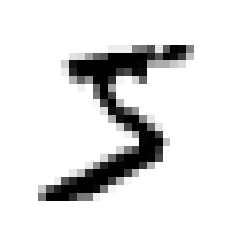

In [9]:
some_digit = X[0]
plot_digit(some_digit)

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
X_train, X_val, y_train, y_val = X_train[:50000], X_train[50000:], y_train[:50000], y_train[50000:]

In [12]:
X_train.shape

(50000, 784)

In [13]:
X_val.shape

(10000, 784)

In [14]:
X_test.shape

(10000, 784)

**Model 1: Logistic Regression**

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
from sklearn.pipeline import Pipeline, make_pipeline

In [17]:
from sklearn.preprocessing import StandardScaler

In [48]:
log_clf = make_pipeline(StandardScaler(), LogisticRegression(solver = 'newton-cg'))

In [49]:
#log_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(solver='newton-cg'))])

In [15]:
from sklearn.metrics import accuracy_score

In [23]:
accuracy_score(log_clf.predict(X_val), y_val)

0.9224

In [16]:
from joblib import dump, load

In [80]:
#dump(log_clf, './models/mnist_log.joblib')

['./models/mnist_log.joblib']

In [22]:
log_clf = load('./models/mnist_log.joblib')

**Model 2: Naive Bayes**

In [24]:
from sklearn.naive_bayes import MultinomialNB

In [25]:
naive_clf = MultinomialNB()

In [26]:
naive_clf.fit(X_train,y_train)

MultinomialNB()

In [27]:
naive_clf.predict(some_digit.reshape(1,-1))

array(['5'], dtype='<U1')

In [28]:
accuracy_score(naive_clf.predict(X_val), y_val)

0.8435

In [29]:
naive_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

**Model 3: SVM**

In [17]:
from sklearn.svm import SVC, LinearSVC

In [38]:
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

In [39]:
svm.fit(X_train[:10000], y_train[:10000])

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [46]:
accuracy_score(svm.predict(X_val), y_val)

0.9454

**Model 4: Decision Trees**

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [61]:
tree_clf = DecisionTreeClassifier(max_depth = 24)

In [62]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=24)

In [63]:
accuracy_score(tree_clf.predict(X_val), y_val)

0.8862

### Ensemble Models

1. Voting

In [19]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [20]:
clf1 = LinearSVC()
clf2 = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf3 = ExtraTreesClassifier(n_estimators= 100, random_state= 42)

In [21]:
estimators = [clf1, clf2, clf3]

In [22]:
for estimator in estimators:
    print("Training the :", estimator)
    estimator.fit(X_train, y_train)

Training the : LinearSVC()


/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training the : RandomForestClassifier(random_state=42)
Training the : ExtraTreesClassifier(random_state=42)


In [23]:
for estimator in estimators:
    print("Accuracy of ", estimator, " is : ", accuracy_score(estimator.predict(X_val), y_val))

Accuracy of  LinearSVC()  is :  0.8578
Accuracy of  RandomForestClassifier(random_state=42)  is :  0.9736
Accuracy of  ExtraTreesClassifier(random_state=42)  is :  0.9743


In [24]:
named_estimators = [
    ('forest_clf', clf2),
    ('extra_trees_clf', clf3),
    ('linearsvm', clf1)
]

In [25]:
voting_clf = VotingClassifier(named_estimators)

In [26]:
voting_clf.fit(X_train,y_train)

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VotingClassifier(estimators=[('forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('linearsvm', LinearSVC())])

In [27]:
accuracy_score(voting_clf.predict(X_val), y_val) #performs bad overall, we need more models

0.9741

In [28]:
# the votingclassifier trained on indices of the class instead of the class labels
y_val_encoded = y_val.astype(np.int64)

In [29]:
y_val

array(['3', '8', '6', ..., '5', '6', '8'], dtype=object)

In [30]:
y_val_encoded

array([3, 8, 6, ..., 5, 6, 8])

In [31]:
[ estimator.score(X_val, y_val_encoded) for estimator in voting_clf.estimators_]

[0.9736, 0.9743, 0.8763]

In [32]:
#svm seems to be affecting the performance here, let's drop that

voting_clf.set_params(linearsvm = "drop")

VotingClassifier(estimators=[('forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('linearsvm', 'drop')])

In [33]:
voting_clf.estimators #updated list of estimators

[('forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('linearsvm', 'drop')]

In [34]:
voting_clf.estimators_ #however svm is still there in trained clones

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC()]

In [35]:
# either we can train votingclassifier again or drop svm

voting_clf.named_estimators_.pop("linearsvm")

LinearSVC()

In [36]:
voting_clf.estimators_.remove(_)

In [37]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42)]

In [38]:
voting_clf.score(X_val, y_val) #even worse because now there are even more similar models 

0.9735

In [39]:
voting_clf.voting = "soft"

In [40]:
voting_clf.score(X_val, y_val) # now the performance is better

0.9749

Comparison on test set

In [41]:
for estimator in estimators:
    print("Accuracy of ", estimator, " is : ", estimator.score(X_test, y_test))
    

Accuracy of  LinearSVC()  is :  0.8598
Accuracy of  RandomForestClassifier(random_state=42)  is :  0.968
Accuracy of  ExtraTreesClassifier(random_state=42)  is :  0.9703


In [42]:
voting_clf.score(X_test, y_test) #extra tress classifier is still better, why?

0.9698

2. stacking

In [46]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=object)

In [54]:
for index,estimator in enumerate(estimators):
    X_val_predictions[:,index] = estimator.predict(X_val)

In [55]:
X_val_predictions

array([['3', '3', '3'],
       ['8', '8', '8'],
       ['6', '6', '6'],
       ...,
       ['5', '5', '5'],
       ['6', '6', '6'],
       ['8', '8', '8']], dtype=object)

In [56]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [57]:
rnd_forest_blender.oob_score_

0.973

In [58]:
#checking accuracy on test set
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)
for index,estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [59]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [60]:
accuracy_score(y_pred, y_test)

0.9684

In [61]:
#using stacking classifier
X_train_full, y_train_full = X[:60_000], y[:60_000]

In [62]:
from sklearn.ensemble import StackingClassifier

In [63]:
stack_clf = StackingClassifier(named_estimators, final_estimator=rnd_forest_blender)

In [64]:
stack_clf.fit(X_train_full, y_train_full)

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/sit

StackingClassifier(estimators=[('forest_clf',
                                RandomForestClassifier(random_state=42)),
                               ('extra_trees_clf',
                                ExtraTreesClassifier(random_state=42)),
                               ('linearsvm', LinearSVC())],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          oob_score=True,
                                                          random_state=42))

In [65]:
stack_clf.score(X_test, y_test)

0.977